In [1]:
# Install Neccessary Packages -- Required for LLMs

%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
        torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
        datasets==2.11.0 --quiet

In [1]:
import datasets # this is huggingface module an efficient way of storing large datasets
import transformers # "Self-Attention is all need" again this module is developed by huggingface team
import timer
from pprintpp import pprint

# datasets related packages
from datasets import load_dataset
from datasets import get_dataset_split_names
from datasets import load_dataset_builder

from transformers import AutoModelForSeq2SeqLM # 
from transformers import AutoTokenizer
from transformers import GenerationConfig

# Summarize Dialogue without Prompt Engineering 

In [2]:
huggingface_dataset_name = 'knkarthick/dialogsum'
dataset = load_dataset(huggingface_dataset_name)

Found cached dataset csv (/Users/ksanthoshkumar/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-3005b557c2c04c1d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|██████████| 3/3 [00:00<00:00, 64.71it/s]


# Datasets Tutorial - Powerful Preprocessing powered by the Huggingface Community

In [3]:
from datasets import load_dataset_builder
from datasets import get_dataset_split_names
df_des = load_dataset_builder(huggingface_dataset_name)

In [4]:
# Incept dataset description
print(f"Dataset Description provided by the user: {df_des.info.description}")

# Inspect dataset features and target Variable 
print(f"Dataset features and target provided by the user: \
                            {df_des.info.features}")


# Get dataset split names 
print(f"Get the dataset splits with respect to the dataset: \
                        {get_dataset_split_names(huggingface_dataset_name)}")

Dataset Description provided by the user: 
Dataset features and target provided by the user:                             {'id': Value(dtype='string', id=None), 'dialogue': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None), 'topic': Value(dtype='string', id=None)}
Get the dataset splits with respect to the dataset:                         ['train', 'test', 'validation']


In [5]:
dataset # Here we have loaded all the splits present in the datasets
# In this case we have train, test and validation splits 

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
})

In [7]:
# Indexing - datasets
dataset['train'][0] # Get the first row of the dataset

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [8]:
dataset['train'][-1] # Get the last row of the dataset

{'id': 'train_12459',
 'dialogue': "#Person1#: Mom, I'm flying to visit uncle Lee's family next Saturday. Should I pack my bags today?\n#Person2#: Yes, I think so.\n#Person1#: OK. What clothes should I take? I know it's hot there.\n#Person2#: Yes, but it rains a lot. You can borrow an umbrella or a jacket if it's wet. Just pack some T-shirts.\n#Person1#: OK. And who is meeting me at the airport?\n#Person2#: Well, uncle Lee and aunt Wong will be busy, but your cousin Susan can pick you up.",
 'summary': "#Person1# asks for #Person2#'s idea of packing the bag when visiting uncle Lee's family next Saturday.",
 'topic': 'baggage pack'}

In [9]:
# Print the shape of the dataset
print(f"Shape of the dataset: {dataset['train'].shape}")

Shape of the dataset: (12460, 4)


In [10]:
# Retrieving records matters
with timer.timer():
    dataset['train'][0]['id']

In [11]:
with timer.timer():
    dataset['train']['id'][0]

# Text Data Preprocessing Steps
    1.  Tokenize Test : Models cannot process text, so we need convert to numbers. Tokenization provides best way to do this by dividing the
        text into individual words called tokens 

    2.  Transformers package provides the autotokenizer depends upon the model that we use, its important to use corresponding tokenizer with
        respect to the pre-trained model

    3.  Here we will use flan-t5-model so corresponding tokenizer should be used to convert text to numbers

# Tokenizer follows some of the preprocessing steps:

    1. Lowercasing the words
    2. Follows set of rules to split into chunks of text
    3. Most of the transformer model use a subword tokenization algorithm
    4. Post splitting if we observe "##" at the start of the word it indicates not start of the word.
    5. Lastly the tokenizer adds some special tokens in case of Bert Model "[cls]" and "[sep]" and roberta uses html syntax

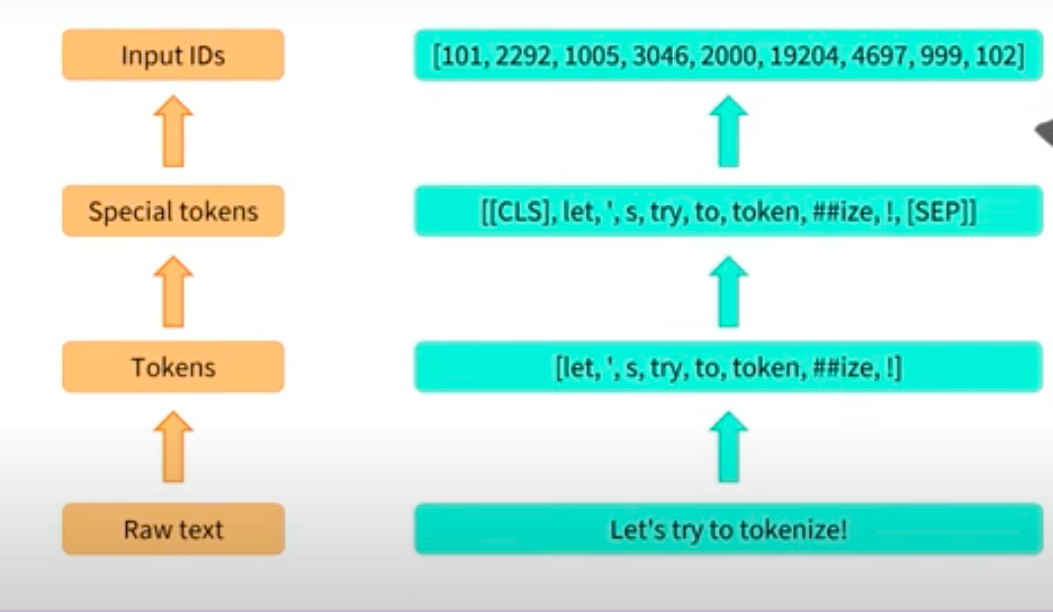

In [12]:
from transformers import AutoTokenizer

model_name = "google/flan-t5-base"
tokenizer_load = AutoTokenizer.from_pretrained(model_name)

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
})

In [14]:
# Testing a Encoding and Decoding of a Sentence
def sample_index_encod_decod(index : int, col_name = 'summary')-> [list, str]:

    sentence = dataset['train'][col_name][index]

    # tokenizer_load converts the text to tokens
    sentence_encode = tokenizer_load(sentence, 
                                     return_tensors='pt')

    # converts from tokens to text
    sentence_decode = tokenizer_load.decode(
        sentence_encode['input_ids'][0],
        skip_special_tokens= True # pretrained tokenizer will be adding some special tokens at the start and end of the text which we be excluding while decoding
    )

    print("Encoded Sentence:")
    print(sentence_encode['input_ids'])
    print("\nDecoded Sentence:")
    print(sentence_decode)  

    return sentence_encode, sentence_decode  


sentence_encode, sentence_decode  = sample_index_encod_decod(index = 50)


Encoded Sentence:
tensor([[ 1713,   345, 13515,   536,  4663,     3, 17001,  4143,     8,  7584,
           250,     3,    88,  3853,  1713,   345, 13515,   536,  4663,   166,
            11,  1971,    12,  6131,  1713,   345, 13515,   536,  4663,    31,
             7,  2182,     5,  1713,   345, 13515,   536,  4663,   845,     3,
            88,   737,    31,    17,  5781,   376,    30,  1730,     5,     1]])

Decoded Sentence:
#Person1# stabbed the victim because he beat #Person1# first and tried to grab #Person1#'s bag. #Person1# says he didn't kill him on purpose.


# Import Hugging face flan t5 model

T5 model is an encoder and decoder model trained on multi-task mixture of unsupervised and supervised tasks

T5 model comes with different sizes

    1.  t5-small
    2.  t5-base
    3.  t5-large
    4.  t5-3b 
    5.  t5-11b

In [16]:
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

 1. Now let's explore how well the base LLM summarizes a dialogue without any prompt engineering.

 2. Prompt Engineering is an act of a human changing the prompt (input) to improve the response for a given task.

In [23]:
dialogue = dataset['train'][0]['dialogue']
summary = dataset['train'][0]['summary']

inputs = tokenizer_load(dialogue, return_tensors='pt')

output = tokenizer_load.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens = 50
    )[0],
    skip_special_tokens=True
)

dash_line ='=='*20
print(f"INPUT PROMPT:\n{dialogue}")
print(dash_line)
print(f"ORIGINAL SUMMARY:\n{summary}")
print(dash_line)
print(f"LLM Completion:\n{output}")

INPUT PROMPT:
#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?
#Person2#: I found it would be a good idea to get a check-up.
#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.
#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?
#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.
#Person2#: Ok.
#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?
#Person2#: Yes.
#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.
#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.
#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.
#Person2#: Ok, thanks doctor.
ORIGINAL SUMMARY:
Mr. Smith's getting a check-up, and 

# Few Shot Inference

Let's explore few shot inference by adding two more full dialogue-summary pairs to your prompt

In [40]:
def prompt_generation(examples_index: list, example_test_index:int) -> str:

    prompt = ""

    for index_s in examples_index:
        dialogue = dataset['train']['dialogue'][index_s]
        summary = dataset['train']['summary'][index_s]

        prompt += f"""
            Dialogue:
            {dialogue}
            What is the summary of the dialogue?
            {summary}
        """

    dialogue = dataset['test']['dialogue'][example_test_index]

    prompt += f"""
        Dialogue:
        {dialogue}
        What is the summary of the dialogue?
    """

    return prompt


one_shot_prompt_input = prompt_generation(examples_index = [30], 
                  example_test_index = 29)

In [41]:
print(one_shot_prompt_input)


            Dialogue:
            #Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little longer?
#Person1#: Yes, take your time, please.
#Person2#: Can we get something to drink? We want two bottles of beer.
#Person1#: Fine.
#Person2#: Could you tell us your specials today?
#Person1#: The special today is steak.
#Person2#: We'll take this steak dinner.
#Person1#: What would you like to go with your steak?
#Person2#: Peas and carrots.
#Person1#: I see. What would you like for dessert?
#Person2#: Icecream, please.
            What is the summary of the dialogue?
            #Person1# serves #Person2# to order two bottles of beer, a steak dinner, and ice cream.
        
        Dialogue:
        #Person1#: Who stands out in your mind as a man or woman of sound character?
#Person2#: If I think of famous people, I think of Abraham Lincoln.
#Person1#: He's the US president, who walked five miles just to give a lady her change, isn't he?
#Person2#: Th

In [42]:
inputs = tokenizer_load(one_shot_prompt_input, return_tensors = 'pt')
len(inputs["input_ids"][0])

407

In [43]:

output = tokenizer_load.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens = 50
    )[0],
    skip_special_tokens = True
)


print(dash_line)
print(f"PROMPT GIVEN:\n{one_shot_prompt_input}\n")
print(dash_line)
print(f"ORIGINAL SUMMARY GIVEN:\n{dataset['test']['summary'][29]}\n")
print(dash_line)
print(f"MODEL GENERATED:\n{output}")

PROMPT GIVEN:

            Dialogue:
            #Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little longer?
#Person1#: Yes, take your time, please.
#Person2#: Can we get something to drink? We want two bottles of beer.
#Person1#: Fine.
#Person2#: Could you tell us your specials today?
#Person1#: The special today is steak.
#Person2#: We'll take this steak dinner.
#Person1#: What would you like to go with your steak?
#Person2#: Peas and carrots.
#Person1#: I see. What would you like for dessert?
#Person2#: Icecream, please.
            What is the summary of the dialogue?
            #Person1# serves #Person2# to order two bottles of beer, a steak dinner, and ice cream.
        
        Dialogue:
        #Person1#: Who stands out in your mind as a man or woman of sound character?
#Person2#: If I think of famous people, I think of Abraham Lincoln.
#Person1#: He's the US president, who walked five miles just to give a lady her change, isn't he?

# Large Language Model Parameters

    1. Temperature
    2. Top-k and Top-p
    3. Stop Sequence
    4. Frequency and Presence Penalties
    5. Context Window
    6. Number of Tokens
    7. Model Size


    Let's get into indetail explanation of these parameters

    Model Size : The model size refers number of parameters that the model is trained, a parameter here means a variable or feature. Most of the models are trained upon billions or millions of the parameters. 

## Hyperparameter: Temperature

    By default this parameter is set to 1.0 that means the output won't change by running every time
    Else, it adds randomness while generating the output.

In [44]:

output = tokenizer_load.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens = 50,
        temperature = 0.30
    )[0],
    skip_special_tokens = True
)


print(dash_line)
print(f"PROMPT GIVEN:\n{one_shot_prompt_input}\n")
print(dash_line)
print(f"ORIGINAL SUMMARY GIVEN:\n{dataset['test']['summary'][29]}\n")
print(dash_line)
print(f"MODEL GENERATED:\n{output}")

PROMPT GIVEN:

            Dialogue:
            #Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little longer?
#Person1#: Yes, take your time, please.
#Person2#: Can we get something to drink? We want two bottles of beer.
#Person1#: Fine.
#Person2#: Could you tell us your specials today?
#Person1#: The special today is steak.
#Person2#: We'll take this steak dinner.
#Person1#: What would you like to go with your steak?
#Person2#: Peas and carrots.
#Person1#: I see. What would you like for dessert?
#Person2#: Icecream, please.
            What is the summary of the dialogue?
            #Person1# serves #Person2# to order two bottles of beer, a steak dinner, and ice cream.
        
        Dialogue:
        #Person1#: Who stands out in your mind as a man or woman of sound character?
#Person2#: If I think of famous people, I think of Abraham Lincoln.
#Person1#: He's the US president, who walked five miles just to give a lady her change, isn't he?

# Hyperparameter: Top K 
    
    Default Value: 50

    This parameters basically considers the vocabulary tokens that having the highest probability further it will filters the number of words based on provided value.

In [45]:

output = tokenizer_load.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens = 50,
        temperature = 0.30,
        top_k = 30
    )[0],
    skip_special_tokens = True
)


print(dash_line)
print(f"PROMPT GIVEN:\n{one_shot_prompt_input}\n")
print(dash_line)
print(f"ORIGINAL SUMMARY GIVEN:\n{dataset['test']['summary'][29]}\n")
print(dash_line)
print(f"MODEL GENERATED:\n{output}")

PROMPT GIVEN:

            Dialogue:
            #Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little longer?
#Person1#: Yes, take your time, please.
#Person2#: Can we get something to drink? We want two bottles of beer.
#Person1#: Fine.
#Person2#: Could you tell us your specials today?
#Person1#: The special today is steak.
#Person2#: We'll take this steak dinner.
#Person1#: What would you like to go with your steak?
#Person2#: Peas and carrots.
#Person1#: I see. What would you like for dessert?
#Person2#: Icecream, please.
            What is the summary of the dialogue?
            #Person1# serves #Person2# to order two bottles of beer, a steak dinner, and ice cream.
        
        Dialogue:
        #Person1#: Who stands out in your mind as a man or woman of sound character?
#Person2#: If I think of famous people, I think of Abraham Lincoln.
#Person1#: He's the US president, who walked five miles just to give a lady her change, isn't he?

In [46]:

output = tokenizer_load.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens = 50,
        temperature = 0.30,
        top_k = 2
    )[0],
    skip_special_tokens = True
)


print(dash_line)
print(f"PROMPT GIVEN:\n{one_shot_prompt_input}\n")
print(dash_line)
print(f"ORIGINAL SUMMARY GIVEN:\n{dataset['test']['summary'][29]}\n")
print(dash_line)
print(f"MODEL GENERATED:\n{output}")

PROMPT GIVEN:

            Dialogue:
            #Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little longer?
#Person1#: Yes, take your time, please.
#Person2#: Can we get something to drink? We want two bottles of beer.
#Person1#: Fine.
#Person2#: Could you tell us your specials today?
#Person1#: The special today is steak.
#Person2#: We'll take this steak dinner.
#Person1#: What would you like to go with your steak?
#Person2#: Peas and carrots.
#Person1#: I see. What would you like for dessert?
#Person2#: Icecream, please.
            What is the summary of the dialogue?
            #Person1# serves #Person2# to order two bottles of beer, a steak dinner, and ice cream.
        
        Dialogue:
        #Person1#: Who stands out in your mind as a man or woman of sound character?
#Person2#: If I think of famous people, I think of Abraham Lincoln.
#Person1#: He's the US president, who walked five miles just to give a lady her change, isn't he?

Although I changed the value from top_k from 50 to 30 and then to 10, I couldn't find much difference let's move ahead

# top_p (float, optional, defaults to 1.0) — 

    If set to float < 1, only the smallest set of most probable tokens with probabilities that add up to top_p or higher are kept for generation.

In [47]:

output = tokenizer_load.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens = 50,
        temperature = 0.30,
        top_k = 2,
        top_p = 15
    )[0],
    skip_special_tokens = True
)


print(dash_line)
print(f"PROMPT GIVEN:\n{one_shot_prompt_input}\n")
print(dash_line)
print(f"ORIGINAL SUMMARY GIVEN:\n{dataset['test']['summary'][29]}\n")
print(dash_line)
print(f"MODEL GENERATED:\n{output}")

PROMPT GIVEN:

            Dialogue:
            #Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little longer?
#Person1#: Yes, take your time, please.
#Person2#: Can we get something to drink? We want two bottles of beer.
#Person1#: Fine.
#Person2#: Could you tell us your specials today?
#Person1#: The special today is steak.
#Person2#: We'll take this steak dinner.
#Person1#: What would you like to go with your steak?
#Person2#: Peas and carrots.
#Person1#: I see. What would you like for dessert?
#Person2#: Icecream, please.
            What is the summary of the dialogue?
            #Person1# serves #Person2# to order two bottles of beer, a steak dinner, and ice cream.
        
        Dialogue:
        #Person1#: Who stands out in your mind as a man or woman of sound character?
#Person2#: If I think of famous people, I think of Abraham Lincoln.
#Person1#: He's the US president, who walked five miles just to give a lady her change, isn't he?